In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pydicom
import numpy as np
from matplotlib import pyplot as plt
from utils import normalize_image,load_dcm_data,sigmoid_contrast
from task1 import rotate_on_axial_plane
from scipy.ndimage import rotate, zoom, shift
from scipy.optimize import least_squares



In [3]:
#Loaf target dcms
dcm_path='RadCTTACEomics_1193-20250418T131346Z-001/RadCTTACEomics_1193/10_AP_Ax2.50mm'
dcms_target=load_dcm_data(dcm_path)
dcms_target.sort(key = (lambda x: float(x.SliceLocation)))
pixelarray_target = np.stack([x.pixel_array for x in dcms_target], axis=0)
pixelarray_target=normalize_image(pixelarray_target)

#Load moving dcms
dcm_path='RadCTTACEomics_1193-20250418T131346Z-001/RadCTTACEomics_1193/30_EQP_Ax2.50mm'
dcms_moving=load_dcm_data(dcm_path)
dcms_moving.sort(key = (lambda x: float(x.SliceLocation)))
pixelarray_moving = np.stack([x.pixel_array for x in dcms_moving], axis=0)
pixelarray_moving=normalize_image(pixelarray_moving)

pixelarray_target.shape, pixelarray_moving.shape


((188, 512, 512), (186, 512, 512))

is necessary volume match for coregistrations, so a solution can be cropped the bigger volume

In [4]:
# Crop the target (reference) to match the moving shape in depth (Z-axis)
depth_moving = pixelarray_moving.shape[0]
pixelarray_target = pixelarray_target[:depth_moving, :, :]
pixelarray_target.shape, pixelarray_moving.shape

((186, 512, 512), (186, 512, 512))

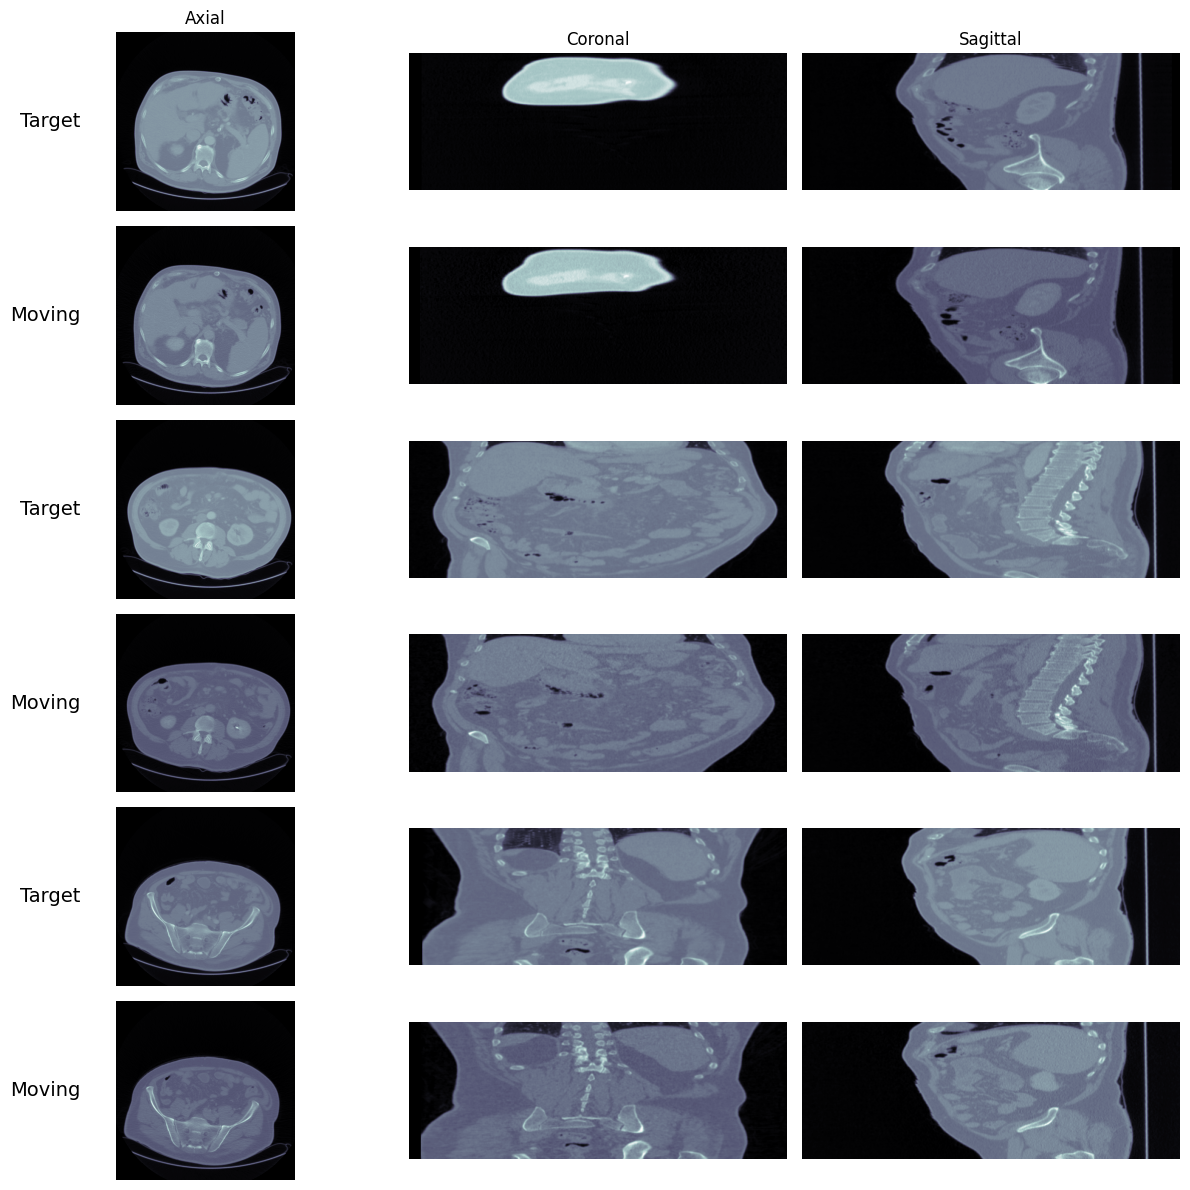

In [26]:

# Image dimensions
depth, height, width = pixelarray_moving.shape

# Choose 3 slice sets (axial, coronal, sagittal indices)
slice_indices = [
    (depth // 4, height // 4, width // 4),
    (depth // 2, height // 2, width // 2),
    (3 * depth // 4, 3 * height // 4, 3 * width // 4),
]

titles = ['Axial', 'Coronal', 'Sagittal']

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.05)

for view_set_idx, (idx_axial, idx_coronal, idx_sagittal) in enumerate(slice_indices):

    # Prepare current slice set
    target_slices = [
        pixelarray_target[idx_axial, :, :],
        pixelarray_target[:, idx_coronal, :],
        pixelarray_target[:, :, idx_sagittal]
    ]
     
    moving_slices = [
        pixelarray_moving[idx_axial, :, :],
        pixelarray_moving[:, idx_coronal, :],
        pixelarray_moving[:, :, idx_sagittal]
    ]

    for row_offset, (slices, label) in enumerate([(target_slices, 'Target'), (moving_slices, 'Moving')]):
        row = view_set_idx * 2 + row_offset
        for col in range(3):
            ax = axes[row, col]
            ax.imshow(slices[col], cmap='bone')
            ax.axis('off')
            
            # Set column titles only for the first row
            if row == 0:
                ax.set_title(titles[col], fontsize=12)
        
        # Add row label on the left of the row
        axes[row, 0].text(-0.2, 0.5, label, fontsize=14, color='black',
                          ha='right', va='center', transform=axes[row, 0].transAxes)

plt.tight_layout()
plt.show()


# Apply Corregistration

Frist we start by defining a error function to minimize in which in this case it will be Root mean square deviation

In [6]:

def rmse_loss(fixed, moving):
    """Compute Root Mean Squared Error between two volumes."""
    if fixed.shape != moving.shape:
        raise ValueError("Shape mismatch: fixed and moving volumes must have the same shape.")
    return np.sqrt(np.mean((fixed - moving) ** 2))

initial_error= rmse_loss(pixelarray_target,pixelarray_moving)
print("Initial error ", initial_error)

Initial error  0.05431146710877256


We also define some util function to apply transformation and to get an initial parameter estimate

In [7]:

def find_volume_centroid(volume: np.ndarray):
    """Compute centroid of non-zero voxels in a 3D volume."""
    nonzero = np.argwhere(volume > 0)
    if nonzero.size == 0:
        raise ValueError("Volume is empty or has no non-zero voxels.")
    return np.mean(nonzero, axis=0)

def rotate_volume_all_axes(volume, angles, order=1):
    """Apply sequential 3D rotation around each principal axis."""
    axes = [(1, 2), (0, 2), (0, 1)]  # axial, coronal, sagittal
    for angle, axis in zip(angles, axes):
        volume = rotate(volume, angle=angle, axes=axis, reshape=False, order=order)
    return volume

def apply_transform(volume, translation, rotation_angles, zoom_factors):
    """Apply shift, rotation, and zoom to a volume."""
    transformed = shift(volume, translation, order=1)
    transformed = rotate_volume_all_axes(transformed, rotation_angles, order=1)
    transformed = zoom(transformed, zoom_factors, order=1)
    return transformed



We firts get the center of volume to get an estimate on the translation, rotation and scale will be empty at the beging

In [8]:
centroid_moving = find_volume_centroid(pixelarray_moving)
centroid_moving = find_volume_centroid(pixelarray_target)
initial_translation = centroid_moving - centroid_moving

# Initial guess: [dx, dy, dz, rx, ry, rz, zx, zy, zz]
initial_params = np.concatenate([
    initial_translation,              # translation
    [0.0, 0.0, 0.0],                  # rotation (in radians/degrees)
    [1.0, 1.0, 1.0]                   # zoom
])


We define the fuction to minimize with least square error

In [9]:
def function_to_minimize(params):
    translation = params[0:3]
    rotation_angles = params[3:6]
    zoom_factors = params[6:9]
    transformed = apply_transform(pixelarray_target, translation, rotation_angles, zoom_factors)
    return rmse_loss(pixelarray_moving, transformed)

result = least_squares(function_to_minimize, x0=initial_params, verbose=1)


`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.4749e-03, final cost 1.4749e-03, first-order optimality 1.12e+04.


In [10]:
result.cost

np.float64(0.001474867729753642)

In [16]:
error_reduce= (1- result.cost/initial_error)*100 
error_reduce

np.float64(97.28442664456138)

We now apply the final parameter obtained from optimization coregistration

In [27]:
final_transform = apply_transform(pixelarray_moving, 
                                      translation=result.x[0:3],
                                      rotation_angles=result.x[3:6],
                                      zoom_factors=result.x[6:9])

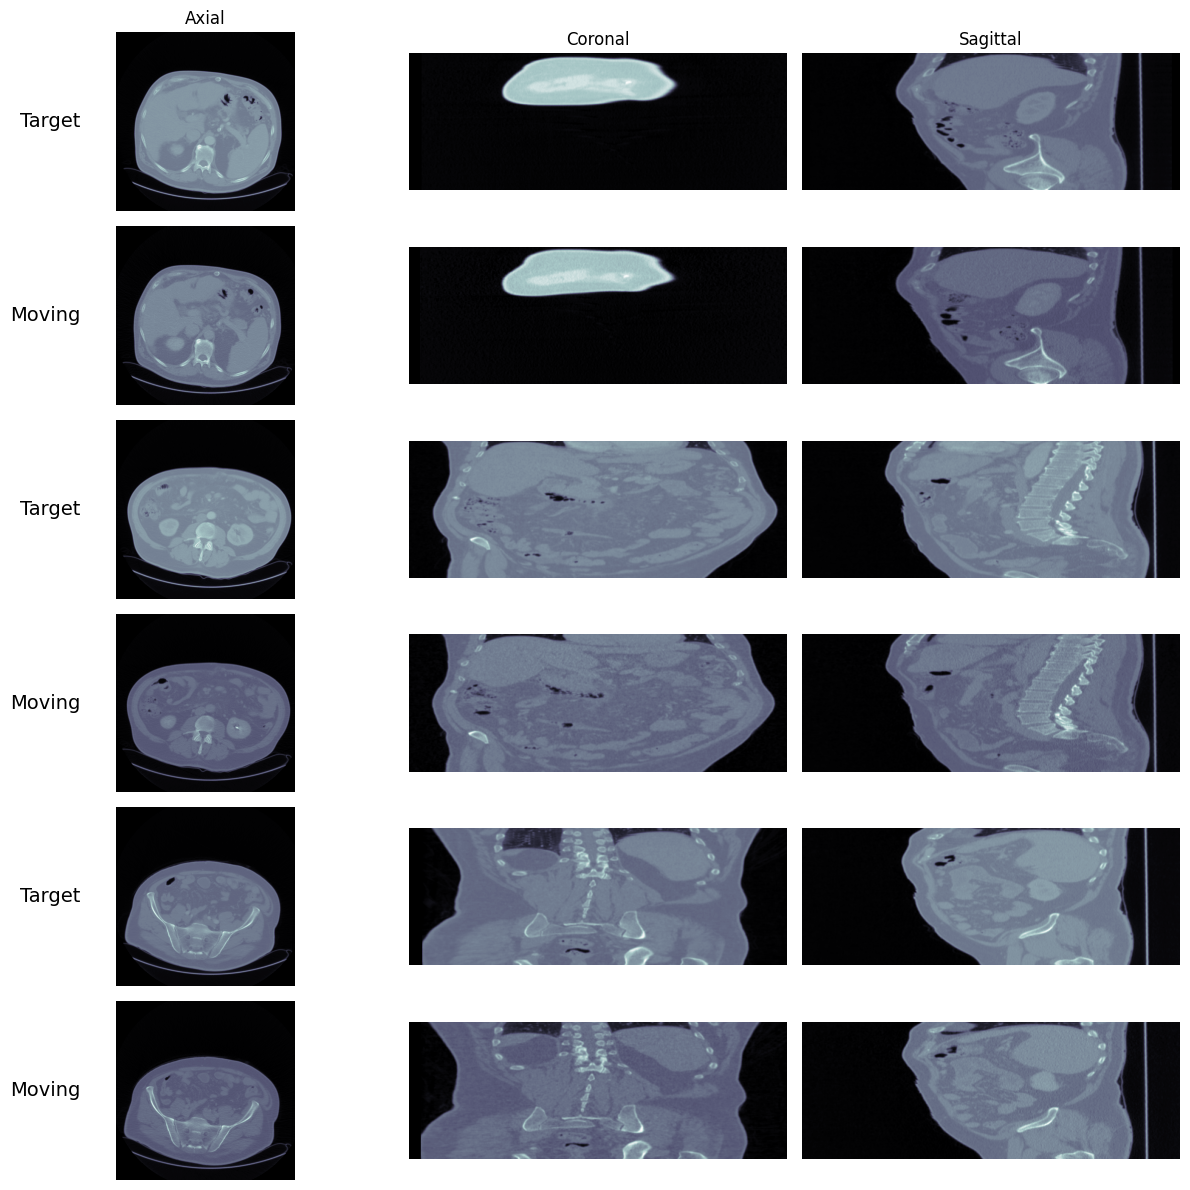

In [28]:

# Image dimensions
depth, height, width = final_transform.shape

# Choose 3 slice sets (axial, coronal, sagittal indices)
slice_indices = [
    (depth // 4, height // 4, width // 4),
    (depth // 2, height // 2, width // 2),
    (3 * depth // 4, 3 * height // 4, 3 * width // 4),
]

titles = ['Axial', 'Coronal', 'Sagittal']

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.05)

for view_set_idx, (idx_axial, idx_coronal, idx_sagittal) in enumerate(slice_indices):

    # Prepare current slice set
    target_slices = [
        pixelarray_target[idx_axial, :, :],
        pixelarray_target[:, idx_coronal, :],
        pixelarray_target[:, :, idx_sagittal]
    ]
     
    moving_slices = [
        final_transform[idx_axial, :, :],
        final_transform[:, idx_coronal, :],
        final_transform[:, :, idx_sagittal]
    ]

    for row_offset, (slices, label) in enumerate([(target_slices, 'Target'), (moving_slices, 'Moving')]):
        row = view_set_idx * 2 + row_offset
        for col in range(3):
            ax = axes[row, col]
            ax.imshow(slices[col], cmap='bone')
            ax.axis('off')
            
            # Set column titles only for the first row
            if row == 0:
                ax.set_title(titles[col], fontsize=12)
        
        # Add row label on the left of the row
        axes[row, 0].text(-0.2, 0.5, label, fontsize=14, color='black',
                          ha='right', va='center', transform=axes[row, 0].transAxes)

plt.tight_layout()
plt.show()
